In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import random as rnd
import collections

import SP_anisotropy_class as SPN

#3D plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
#Ignore the first 50 elements of the output
spacer = 50

In [3]:
def build_optimal_list_rec(L,sequences,p):
    #print(L)
    if len(L)==2**p:
        if check_cyclic_seq(L,sequences,p):
            L_final = L
            return(True,L_final)
        else:
            return(False,[0])
    else:
        #Add a 0
        L.append(0)
        last_seq = get_last_sequence(L,p)
        if check_last_seq(last_seq,sequences):
            sequences.append(last_seq)
            (success,L_final) = build_optimal_list_rec(L,sequences,p)
            if success:
                return(True,L_final)
        L.pop()
        
        #Add a 1
        L.append(1)
        last_seq = get_last_sequence(L,p)
        if check_last_seq(last_seq,sequences):
            sequences.append(last_seq)
            (success,L_final) = build_optimal_list_rec(L,sequences,p)
            if success:
                return(True,L_final)
        L.pop()
        return(False,[0])
            
def get_last_sequence(L,p):
    key = 0
    for k in range(p):
        key += (L[-p+k])*10**(p-k-1)
    key = int(key)
    return(key)


def check_last_seq(last_seq,sequences):
    if last_seq in sequences:
        return False
    else:
        return True

def check_cyclic_seq(L,sequences,p):
    L_cyclic = L[-p+1:]+L[:p-1]
    for k in range(p-1):
        last_seq = get_last_sequence(L_cyclic[k:k+p],p)
        if check_last_seq(last_seq,sequences)==False:
            return False
    return True

In [4]:
def Ridge_regression(S, Y, alpha):
    '''
    For a linear layer we can solve the weights by a direct method
    If the error function is the mean square error given by
        E = |Y - S * W |^2 + \alpha |W|^2
    where the L2 norm is being applied and the variables are
        Y = [Nsamples x Noutputs] is the desired output
        S = [Nsamples x Nweights] is the input signal
        W = [Nweights x Noutputs] is the weight matrix
    To minimise E we need to solve:
        S^T * Y = (S^T * S  + \alpha I) * W
        W = (S^T*S + \alpha I)^-1 * S^T * Y
    '''
    STS = np.matmul(S.T, S)
    STY = np.matmul(S.T, Y)
    Sdag = np.linalg.pinv(STS + alpha*np.eye(len(STS)))
    return(np.matmul(Sdag, STY))

def NARMA10(Ns):
    # Ns is the number of samples
    u = np.random.random(Ns+50+spacer)*0.5
    y = np.zeros(Ns+50+spacer)
    for k in range(10,Ns+50+spacer):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return(u[50:],y[50+spacer:])

def mask_NARMA10(m0,Nvirt):
    # Nvirt is the number of virtual nodes
    mask = []
    for i in range(Nvirt):
        mask.append(rnd.choice([-1,1])*m0)
    return(mask)

def mask_positive_ac(m0,Nvirt):
    #Mask with strong positive autocorrelation
    mask = []
    for i in range(Nvirt):
        mask.append(m0)
    return(mask)

def mask_negative_ac(m0,Nvirt):
    #Mask with strong negative autocorrelation
    mask = []
    for i in range(Nvirt):
        mask.append(2*((i%2)-0.5)*m0)
    return(mask)

def mask_random(m0,Nvirt):
    #Random mask
    mask = []
    for i in range(Nvirt):
        mask.append(2*(rnd.random()-0.5)*m0)
    return(mask)

def mask_switch(m0,Nvirt,K_switch_max):
    #Mask with as many "combinations of products" as possible
    mask = []
    K_switch = 1
    k_current = 0
    sign = 1
    while len(mask)<Nvirt:
        mask.append(sign*m0)
        k_current += 1
        if k_current==K_switch:
            k_current = 0
            if sign==1:
                sign=-1
            else:
                sign=1
                K_switch+=1
                if K_switch>K_switch_max:
                    K_switch=1
    return(mask)

def mask_max_sequences(m0,Nvirt):
    p = int(np.log2(Nvirt))
    L = [1]*p
    (success,L_final) = build_optimal_list_rec(L,[],p)
    mask = [0]*Nvirt
    N_L = len(L_final)
    for i in range(N_L):
        mask[i] = m0*2*(L_final[i]-0.5)
    for i in range(Nvirt-N_L):
        mask[-1-i] = m0*2*(L_final[-1-i]-0.5)
    print(mask)
    return(mask)

def NRMSE(Y,Y_pred):
    var = np.var(Y)
    return np.sqrt(np.square(Y_pred-Y).mean()/var)

def NRMSE_list(y,y_pred):
    Y = np.array(y)
    Y_pred = np.array(y_pred)
    return(NRMSE(Y,Y_pred))

In [5]:
h = 0.4
theta_H = 90
k_s_0 = 0
phi = 45
f0 = 1e10
class Single_Node_Reservoir_NARMA10:
    
    def __init__(self, Nvirt, T_theta_ratio, m0, gamma, beta_prime = 10, k_off = 0., bias = True, joined_states = False, mask_type = "Default", K_switch_max = 4):
        self.Nin = 1
        self.Nvirt = Nvirt
        self.Nout = 1
        
        self.spn = SPN.SP_Network(h,theta_H,k_s_0,phi,beta_prime)
        SPN.calculate_energy_barriers(self.spn)
        self.T = 1./(self.spn.get_omega_prime()*f0)
        self.theta = self.T/T_theta_ratio
        self.tau = self.Nvirt*self.theta
        
        self.m0 = m0
        if mask_type=="Positive":
            self.M = mask_positive_ac(m0,Nvirt)
        elif mask_type=="Negative":
            self.M = mask_negative_ac(m0,Nvirt)
        elif mask_type=="Random":
            self.M = mask_random(m0,Nvirt)
        elif mask_type=="Max_Product":
            self.M = mask_switch(m0,Nvirt,K_switch_max)
        elif mask_type=="Max_Sequences":
            self.M = mask_max_sequences(m0,Nvirt)
        else:
            self.M = mask_NARMA10(m0,Nvirt)
            
        if bias:
            if joined_states:
                self.W = np.zeros((2*Nvirt+1,1))
            else:
                self.W = np.zeros((Nvirt+1,1))
        else:
            if joined_states:
                self.W = np.zeros((2*Nvirt,1))
            else:
                self.W = np.zeros((Nvirt,1))
        
        self.gamma = gamma
        self.k_off = k_off
        
        self.use_bias = bias
    
    def gen_signal(self, u):
        Ns = len(u)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback
                SPN.calculate_energy_barriers(self.spn)
                self.spn.evolve(f0,self.theta)
                S[k,i] = self.spn.get_m()
        
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast(self,u):
        Ns = len(u)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
        
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast_2_inputs(self, u, back_input_ratio):
        Ns = len(u)
        Nin = int(self.Nvirt*back_input_ratio)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(Nin):
                #Input at k-1
                j = self.M[i]*u[k-1] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
            for i in range(Nin,self.Nvirt):
                #Input at k
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
                
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast_delayed_feedback(self, u, delay_fb):
        Ns = len(u)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i-delay_fb] #Delayed Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
                
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_delayed_feedback_without_SPN(self, u, delay_fb):
        Ns = len(u)
        if self.use_bias:
            J = np.zeros((Ns,self.Nvirt+1))
        else:
            J = np.zeros((Ns,self.Nvirt))
            
        # Artificial nonlinearity
        #f = lambda x: x
        f=np.tanh
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                J[k,i] = f(j + self.gamma*J[k-1,i-delay_fb]) #Delayed Feedback 
                
        if self.use_bias:
            for k in range(Ns):
                J[k,self.Nvirt] = 1
        
        return(J[spacer:])
    
    def gen_signal_without_SPN(self,u):
        Ns = len(u)
        if self.use_bias:
            J = np.zeros((Ns,self.Nvirt+1))
        else:
            J = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                J[k,i] = j + self.gamma*J[k-1,i] #J will be useful to test the role of memory and nonlinearity
        
        if self.use_bias:
            for k in range(Ns):
                J[k,self.Nvirt] = 1
        
        return(J[spacer:])
    
    def train(self, S, y, S_valid, y_valid):
        alphas = np.logspace(-15,0,20)
        alphas[0] = 0.
        
        Ns = S.shape[0]
        Ns_valid = S_valid.shape[0]
        Y = y.reshape((Ns,1))
        Y_valid = y_valid.reshape((Ns_valid,1))
        
        errs = np.zeros(alphas.shape)
        for i in range(len(alphas)):
            self.W = Ridge_regression(S, Y, alphas[i])
            Y_pred = np.array(self.predict(S)).reshape(Ns,1)
            Y_pred_valid = np.array(self.predict(S_valid)).reshape(Ns_valid,1)
            errs[i] = NRMSE(Y_valid, Y_pred_valid)
            print("alpha = " + str(alphas[i]) + " ; NRMSE (train) = " + str(int(1000*NRMSE(Y,Y_pred))/1000) + " ; NRMSE (validation) = " + str(int(1000*NRMSE(Y_valid, Y_pred_valid))/1000))
    
        alpha_opt = alphas[np.argmin(errs)]
        print('Optimal alpha = ' + str(alpha_opt) + ' with NRMSE (validation) = ' + str(np.min(errs)))
        self.W = Ridge_regression(S, Y, alpha_opt)
    
    def train_without_SPN(self, J, y, J_valid, y_valid):
        alphas = np.logspace(-15,0,20)
        alphas[0] = 0.
        
        Ns = J.shape[0]
        Ns_valid = J_valid.shape[0]
        Y = y.reshape((Ns,1))
        Y_valid = y_valid.reshape((Ns_valid,1))
        
        errs = np.zeros(alphas.shape)
        for i in range(len(alphas)):
            self.W = Ridge_regression(J, Y, alphas[i])
            Y_pred_valid = np.array(self.predict(J_valid)).reshape(Ns_valid,1)
            errs[i] = NRMSE(Y_valid, Y_pred_valid)
            print(alphas[i], NRMSE(Y_valid, Y_pred_valid))
    
        alpha_opt = alphas[np.argmin(errs)]
        print('Optimal alpha = '+str(alpha_opt)+' with NRMSE = '+str(np.min(errs)))
        self.W = Ridge_regression(J, Y, alpha_opt)
    
    def predict(self, S):
        Ns = S.shape[0]
        return(np.matmul(S, self.W).reshape(1,Ns).tolist()[0])
    
    #Time lists (in ns)
    
    def get_time_list_u(self, u):
        #We need to make sure that time_u has Ns elements with a delay tau
        Ns = len(u)
        t_u = 0
        time_u = [t_u]
        while len(time_u)<Ns:
            t_u += self.tau
            time_u.append(t_u)
        return(np.array(time_u)*1e9)
    
    def get_time_list_y(self, y):
        #We need to make sure that time_y has Ns elements with a delay tau
        Ns = len(y)
        t_y = spacer*self.tau
        time_y = [t_y]
        while len(time_y)<Ns:
            t_y += self.tau
            time_y.append(t_y)
        return(np.array(time_y)*1e9)
    
    def get_time_list_S(self, S):
        Ns = S.shape[0]
        return(np.arange(spacer*self.tau,(Ns+spacer)*self.tau,self.theta)*1e9)
    
    #Joined states
    
    def get_joined_states_signal(self, S):
        Ns = S.shape[0]
        if self.use_bias:
            S_joined = np.zeros((Ns,2*self.Nvirt+1))
        else:
            S_joined = np.zeros((Ns,2*self.Nvirt))
            
        for k in range(Ns):
            S_joined[k,:self.Nvirt] = S[k-1,:self.Nvirt]
            S_joined[k,self.Nvirt:2*self.Nvirt] = S[k,:self.Nvirt]
            if self.use_bias:
                S_joined[k,-1] = 1
        
        return(S_joined)

In [42]:
mask_type_list = ["Default","Positive","Negative","Random"]

Nv = 400
T_theta = .3
m0 = 7e-2
gamma = .28

N = 5

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for MT in mask_type_list:
    print(MT)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT)

        S = net.gen_signal_fast_delayed_feedback(u,1)
        S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
        S_test = net.gen_signal_fast_delayed_feedback(u_test,1)

        net.train(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

Default
0
100
0
100
0
alpha = 0.0 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.4

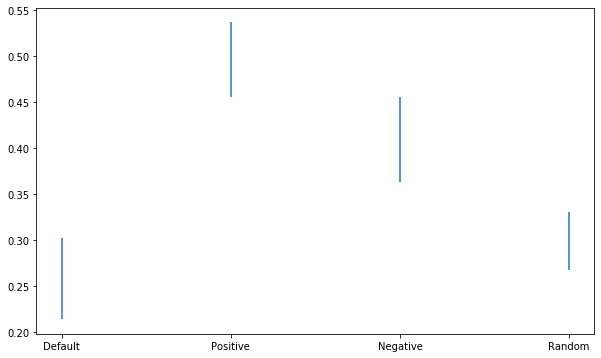

In [19]:
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

In [57]:
K_switch_max_list = [-1,2,4,8,16]

Nv = 400
T_theta = .3
m0 = 7e-2
gamma = .28

N = 10

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for K_s_m in K_switch_max_list:
    print(K_s_m)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    MT = "Max_Product"
    if K_s_m<1:
        MT = "Default"
        
    print(MT)
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT,K_switch_max=K_s_m)

        S = net.gen_signal_fast_delayed_feedback(u,1)
        S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
        S_test = net.gen_signal_fast_delayed_feedback(u_test,1)

        net.train(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

-1
Default
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.134 ; NRMSE (val

alpha = 0.000695192796177562 ; NRMSE (train) = 0.201 ; NRMSE (validation) = 0.268
alpha = 0.004281332398719396 ; NRMSE (train) = 0.287 ; NRMSE (validation) = 0.333
alpha = 0.026366508987303555 ; NRMSE (train) = 0.351 ; NRMSE (validation) = 0.381
alpha = 0.16237767391887242 ; NRMSE (train) = 0.382 ; NRMSE (validation) = 0.399
alpha = 1.0 ; NRMSE (train) = 0.406 ; NRMSE (validation) = 0.42
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.2372058746850218
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 8.858667904

alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.243
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.241
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.152 ; NRMSE (validation) = 0.234
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.163 ; NRMSE (validation) = 0.227
alpha = 0.000695192796177562 ; NRMSE (train) = 0.202 ; NRMSE (validation) = 0.253
alpha = 0.004281332398719396 ; NRMSE (train) = 0.275 ; NRMSE (validation) = 0.317
alpha = 0.

alpha = 1.0 ; NRMSE (train) = 0.802 ; NRMSE (validation) = 0.792
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.41505149226045485
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.414
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.414
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.414
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.413
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.41
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.367 ; NRMSE (validation) = 0.407
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.368 ; NRMSE (validation) = 0.406
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.37 ; NRMSE (validation) = 0.405
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.37 ; NRMSE (validation) = 0.404
alpha = 1.274274

alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.416
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.382 ; NRMSE (validation) = 0.415
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.383 ; NRMSE (validation) = 0.414
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.385 ; NRMSE (validation) = 0.412
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.387 ; NRMSE (validation) = 0.412
alpha = 0.000695192796177562 ; NRMSE (train) = 0.39 ; NRMSE (validation) = 0.415
alpha = 0.004281332398719396 ; NRMSE (train) = 0.399 ; NRMSE (validation) = 0.429
alpha = 0.026366508987303555 ; NRMSE (train) = 0.449 ; NRMSE (validation) = 0.486
alpha = 0.16237767391887242 ; NRMSE (train) = 0.608 ; NRMSE (validation) = 0.637
alpha = 1.0 ; NRMSE (train) = 0.786 ; NRMSE (validation) = 0.8
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.4125327026145474
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
al

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.456
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.455
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.455
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.455
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.456
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.354 ; NRMSE (validation) = 0.46
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.355 ; NRMSE (validation) = 0.453
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.357 ; NRMSE (validation) = 0.452
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.36 ; NRMSE (validation) = 0.449
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.363 ; NRMSE (validation) = 0.448
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.365 ; NRMSE (validation) = 0.446
alpha = 4.832930238571752e-07 ; NRMSE (

alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.341 ; NRMSE (validation) = 0.393
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.343 ; NRMSE (validation) = 0.39
alpha = 0.000695192796177562 ; NRMSE (train) = 0.346 ; NRMSE (validation) = 0.39
alpha = 0.004281332398719396 ; NRMSE (train) = 0.352 ; NRMSE (validation) = 0.394
alpha = 0.026366508987303555 ; NRMSE (train) = 0.38 ; NRMSE (validation) = 0.411
alpha = 0.16237767391887242 ; NRMSE (train) = 0.478 ; NRMSE (validation) = 0.494
alpha = 1.0 ; NRMSE (train) = 0.632 ; NRMSE (validation) = 0.647
Optimal alpha = 0.000695192796177562 with NRMSE (validation) = 0.39067624784281746
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.427
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.427
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.427
alpha = 2.3357214690

alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.316 ; NRMSE (validation) = 0.535
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.316 ; NRMSE (validation) = 0.536
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.318 ; NRMSE (validation) = 0.536
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.32 ; NRMSE (validation) = 0.536
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.321 ; NRMSE (validation) = 0.536
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.323 ; NRMSE (validation) = 0.535
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.325 ; NRMSE (validation) = 0.534
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.329 ; NRMSE (validation) = 0.534
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.331 ; NRMSE (validation) = 0.535
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.332 ; NRMSE (validation) = 0.536
alpha = 0.000695192796177562 ; NRMSE (train) = 0.335 ; NRMSE (validation) = 0.537
alpha = 0.004281332398719396 ; NRMSE (train) = 0.34 ; NRMSE (validation) = 0.539
alph

alpha = 1.0 ; NRMSE (train) = 0.455 ; NRMSE (validation) = 0.463
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.39238960390483457
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.433 ; NRMSE (validation) = 0.479
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.467
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.427 ; NRMSE (validation) = 0.465
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.429 ; NRMSE (validation) = 0.462
alpha = 1.27427498

alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.318 ; NRMSE (validation) = 0.378
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.318 ; NRMSE (validation) = 0.377
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.319 ; NRMSE (validation) = 0.374
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.323 ; NRMSE (validation) = 0.371
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.332 ; NRMSE (validation) = 0.371
alpha = 0.000695192796177562 ; NRMSE (train) = 0.34 ; NRMSE (validation) = 0.375
alpha = 0.004281332398719396 ; NRMSE (train) = 0.351 ; NRMSE (validation) = 0.381
alpha = 0.026366508987303555 ; NRMSE (train) = 0.369 ; NRMSE (validation) = 0.392
alpha = 0.16237767391887242 ; NRMSE (train) = 0.394 ; NRMSE (validation) = 0.409
alpha = 1.0 ; NRMSE (train) = 0.439 ; NRMSE (validation) = 0.448
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.3716221734125093
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500


300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.295 ; NRMSE (validation) = 0.375
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.297 ; NRMSE (validation) = 0.374
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.301 ; NRMSE (validation) = 0.374
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.304 ; NRMSE (validation) = 0.373
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.306 ; NRMSE (validation) = 0.373
alpha = 4.832930238571752e-07 ; NRMSE (train) =

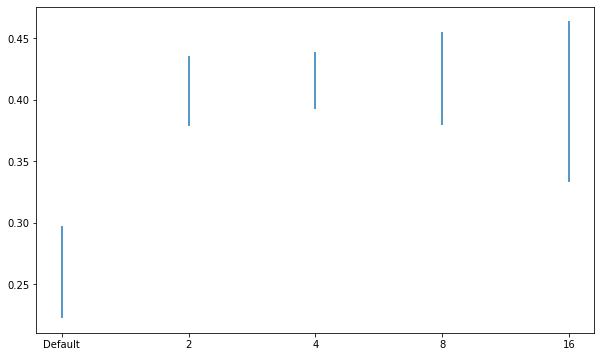

In [58]:
plt.figure(figsize=(10,6))
plt.errorbar(range(len(K_switch_max_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(K_switch_max_list)),["Default"]+K_switch_max_list[1:])
plt.show()

In [ ]:
mask_type_list = ["Max_Sequences","Default"]

Nv = 400
T_theta = .3
m0 = 7e-2
gamma = .28

N = 5

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for MT in mask_type_list:
    print(MT)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT)

        S = net.gen_signal_fast_delayed_feedback(u,1)
        S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
        S_test = net.gen_signal_fast_delayed_feedback(u_test,1)

        net.train(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

In [38]:
Ntrain = 1000
Nvalid = 1000

(u,y) = NARMA10(Ntrain)
(u_valid,y_valid) = NARMA10(Nvalid)

net = Single_Node_Reservoir_NARMA10(20,3e-1,7e-2,0.28,mask_type="Max_Product")
print(net.M)
S = net.gen_signal_fast_delayed_feedback(u, 1)
S_valid = net.gen_signal_fast_delayed_feedback(u_valid, 1)

net.train(S,y,S_valid,y_valid)

y_pred_train = net.predict(S)
y_pred_valid = net.predict(S_valid)

Ntest = 500
(u_test,y_test) = NARMA10(Ntest)
S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
y_pred_test = net.predict(S_test)

[0.07, -0.07, 0.07, 0.07, -0.07, -0.07, 0.07, 0.07, 0.07, 0.07, -0.07, -0.07, -0.07, -0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
alpha = 0.0 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.395 

NRMSE (test) = 0.34882277354954594


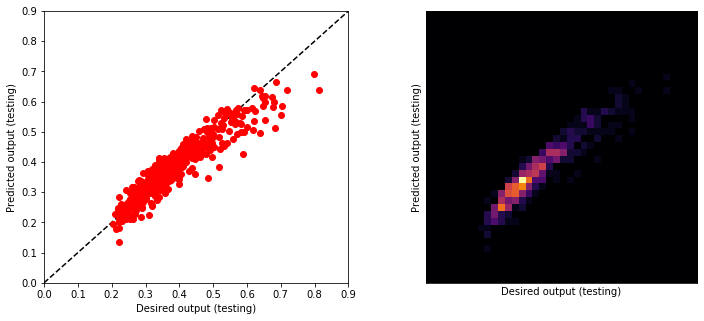

In [32]:
print("NRMSE (test) = "+str(NRMSE_list(y_test,y_pred_test)))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(y_test,y_pred_test,'ro')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xlim(0,0.9)
plt.ylim(0,0.9)
plt.subplot(122)
nbins = int(2*np.sqrt(Ntest))
H, xedges, yedges  = np.histogram2d(y_test,y_pred_test,bins = nbins,range=[[0, 1], [0, 1]])
H = H.T
plt.imshow(H,origin='low',cmap='inferno')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xticks([],[''])
plt.yticks([],[''])
plt.xlim(0,0.9*nbins)
plt.ylim(0,0.9*nbins)
plt.show()

In [33]:
Ntrain = 1000
Nvalid = 1000

(u,y) = NARMA10(Ntrain)
(u_valid,y_valid) = NARMA10(Nvalid)

net = Single_Node_Reservoir_NARMA10(200,3e-1,7e-2,0.28,joined_states=True)
S = net.gen_signal_fast_delayed_feedback(u, 1)
S_valid = net.gen_signal_fast_delayed_feedback(u_valid, 1)
S_joined = net.get_joined_states_signal(S)
S_valid_joined = net.get_joined_states_signal(S_valid)

net.train(S_joined,y,S_valid_joined,y_valid)

y_pred_train = net.predict(S_joined)
y_pred_valid = net.predict(S_valid_joined)

Ntest = 500
(u_test,y_test) = NARMA10(Ntest)
S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
S_test_joined = net.get_joined_states_signal(S_test)
y_pred_test = net.predict(S_test_joined)

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
alpha = 0.0 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.727
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.712
alpha = 4.832930238571752

NRMSE (test) = 0.40595823632037975


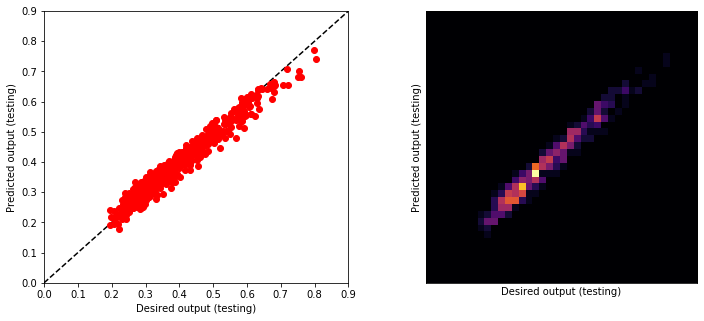

In [34]:
print("NRMSE (test) = "+str(NRMSE_list(y_test,y_pred_test)))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(y_test,y_pred_test,'ro')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xlim(0,0.9)
plt.ylim(0,0.9)
plt.subplot(122)
nbins = int(2*np.sqrt(Ntest))
H, xedges, yedges  = np.histogram2d(y_test,y_pred_test,bins = nbins,range=[[0, 1], [0, 1]])
H = H.T
plt.imshow(H,origin='low',cmap='inferno')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xticks([],[''])
plt.yticks([],[''])
plt.xlim(0,0.9*nbins)
plt.ylim(0,0.9*nbins)
plt.show()

In [ ]:
def count_seq(mask_type,p,Nvirt,K_switch_max=4):
    mask = []
    if mask_type=="Positive":
        mask = mask_positive_ac(1,Nvirt)
    elif mask_type=="Negative":
        mask = mask_negative_ac(1,Nvirt)
    elif mask_type=="Max_Product":
        mask = mask_switch(1,Nvirt,K_switch_max)
    else:
        mask = mask_NARMA10(1,Nvirt)
    sequences = []
    for i in range(Nvirt-p+1):
        key = 0
        for k in range(p):
            key += ((mask[i+k]+1)/2)*10**(p-k-1)
        key = int(key)
        sequences.append(key)
    counter=collections.Counter(sequences)
    return(counter)

In [ ]:
mask_type_1 = "Max_Product"
mask_type_2 = "Default"
p = 8
Nv = 300
K_s_m = 6
counter_1 = count_seq(mask_type_1,p,Nv,K_switch_max = K_s_m)
print(counter_1.keys())
print(counter_1.values())
print(2**p-len(counter_1.values()))
counter_2 = count_seq(mask_type_2,p,Nv,K_switch_max = K_s_m)
print(counter_2.keys())
print(counter_2.values())
print(2**p-len(counter_2.values()))
list_missed = []
for x in counter_2.keys():
    list_missed.append(x)
for x in counter_1.keys():
    if x in list_missed:
        list_missed.remove(x)
print(list_missed)